# Plot posterior predictive checks for simulated populations

In [57]:
import arviz as az
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.stats import gamma
import seaborn as sns

In [58]:
rng = default_rng(314159)

Load original data used to fit a model.

In [8]:
distances = pd.read_csv("../results/model_inputs_for_simulated_populations.tsv", sep="\t")

In [9]:
distances.head()

,horizon,future_timepoint,distance,initial_timepoint,delay,t,future_timepoint_numeric
0,3,2017-01-01,3.752716,2016-10-01,0.0,1,2017.00
1,3,2017-04-01,3.570265,2017-01-01,0.0,2,2017.25
2,3,2017-07-01,3.360436,2017-04-01,0.0,3,2017.50
3,3,2017-10-01,3.414185,2017-07-01,0.0,4,2017.75
4,3,2018-01-01,3.175727,2017-10-01,0.0,5,2018.00


In [11]:
delay_mean = distances["delay"].mean()
delay_sd = distances["delay"].std()

In [13]:
distances["delay_s"] = (distances["delay"] - delay_mean) / delay_sd

In [14]:
horizon_mean = distances["horizon"].mean()
horizon_sd = distances["horizon"].std()

In [15]:
distances["horizon_s"] = (distances["horizon"] - horizon_mean) / horizon_sd

In [16]:
distances.head()

,horizon,future_timepoint,distance,initial_timepoint,delay,t,future_timepoint_numeric,delay_s,horizon_s
0,3,2017-01-01,3.752716,2016-10-01,0.0,1,2017.00,-1.068574,-1.329316
1,3,2017-04-01,3.570265,2017-01-01,0.0,2,2017.25,-1.068574,-1.329316
2,3,2017-07-01,3.360436,2017-04-01,0.0,3,2017.50,-1.068574,-1.329316
3,3,2017-10-01,3.414185,2017-07-01,0.0,4,2017.75,-1.068574,-1.329316
4,3,2018-01-01,3.175727,2017-10-01,0.0,5,2018.00,-1.068574,-1.329316


Load posterior samples exported from rethinking/Stan analysis in R.

In [4]:
posterior = pd.read_csv("../results/simulated_posterior.csv")

In [6]:
posterior.head()

,a,b_s,b_h,scale
0,1.72909,0.085513,0.177240,0.287720
1,1.72775,0.076001,0.188650,0.307304
2,1.72152,0.073518,0.167994,0.331071
3,1.72924,0.078137,0.173487,0.314909
4,1.72059,0.076857,0.178019,0.304466


## Plot distance to the present represented by intercept term

Calculate distance to the present without delays by setting delay=0 and horizon=0.

In [24]:
mu = np.exp(posterior["a"] + posterior["b_s"] * ((0 - delay_mean) / delay_sd) + posterior["b_h"] * ((0 - horizon_mean) / horizon_sd))

In [25]:
mu.head()

0    3.468201
1    3.411292
2    3.558862
3    3.525463
4    3.464793
dtype: float64

In [26]:
scale = posterior["scale"]

In [59]:
average_distance_to_present = gamma.rvs(a=mu / scale, scale=scale, random_state=rng)

In [60]:
average_distance_to_present.shape

(10000,)

In [61]:
bins = np.arange(average_distance_to_present.min(), average_distance_to_present.max() + 0.1, 0.25)

In [62]:
mean_average_distance_to_present = average_distance_to_present.mean()

In [63]:
mean_average_distance_to_present

3.503018012962025

In [64]:
lower_hpdi_average_distance_to_present, upper_hpdi_average_distance_to_present = az.hdi(average_distance_to_present, 0.89)

In [65]:
lower_hpdi_average_distance_to_present

1.791752323687341

In [66]:
upper_hpdi_average_distance_to_present

5.012854093214664

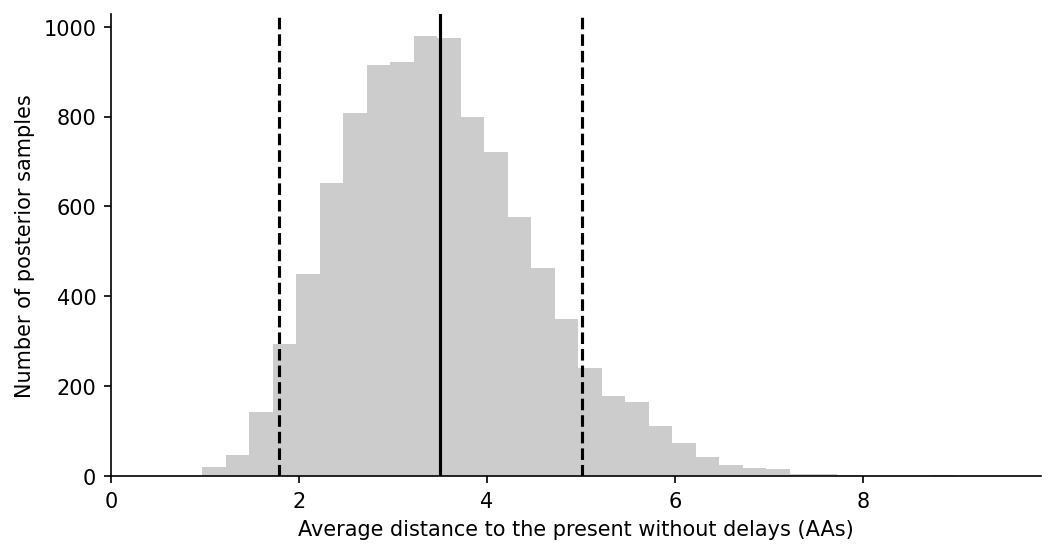

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)

ax.hist(
    average_distance_to_present,
    bins=bins,
    color="#CCCCCC",
)

ax.axvline(x=mean_average_distance_to_present, color="#000000")
ax.axvline(x=lower_hpdi_average_distance_to_present, color="#000000", linestyle="--")
ax.axvline(x=upper_hpdi_average_distance_to_present, color="#000000", linestyle="--")

ax.set_xlim(left=0)

ax.set_xlabel("Average distance to the present without delays (AAs)")
ax.set_ylabel("Number of posterior samples")

sns.despine()

## Plot effect of delays on distance to present

Create a sequence of average submission delays with standardization.

In [97]:
delay_seq = np.arange(0, 4)

In [98]:
delay_seq_s = (delay_seq - delay_mean) / delay_sd

In [99]:
delay_seq_s

array([-1.0685735 , -0.26714338,  0.53428675,  1.33571688])

In [100]:
mu_mean_for_delays = []
mu_lower_hpdi = []
mu_upper_hpdi = []
distance_lower_hpdi = []
distance_upper_hpdi = []

for delay_s in delay_seq_s:
    mu = np.exp(posterior["a"] + posterior["b_s"] * delay_s + posterior["b_h"] * ((0 - horizon_mean) / horizon_sd))
    mu_mean_for_delays.append(mu.mean())
    
    mu_lower_hpdi_for_delay, mu_upper_hpdi_for_delay = az.hdi(mu.values, 0.89)
    mu_lower_hpdi.append(mu_lower_hpdi_for_delay)
    mu_upper_hpdi.append(mu_upper_hpdi_for_delay)
    
    scale = posterior["scale"]
    distance_for_delay = gamma.rvs(a=mu / scale, scale=scale, random_state=rng)
    distance_lower_hpdi_for_delay, distance_upper_hpdi_for_delay = az.hdi(distance_for_delay, 0.89)
    distance_lower_hpdi.append(distance_lower_hpdi_for_delay)
    distance_upper_hpdi.append(distance_upper_hpdi_for_delay)

In [101]:
mu_mean_for_delays

[3.5066040633454025, 3.7165420106426303, 3.939157901266928, 4.175223836276788]

In [102]:
mu_lower_hpdi

[3.4027377707605857, 3.6115477873492168, 3.826070084144875, 4.038975883219127]

In [103]:
mu_upper_hpdi

[3.6137908386209503, 3.819029974740498, 4.0495327060288915, 4.29819198130467]

In [104]:
distance_lower_hpdi

[1.924519076998493, 2.049550715902253, 2.2387707405053088, 2.317069175954508]

In [105]:
distance_upper_hpdi

[5.105030331159247, 5.326563633442561, 5.580682992827577, 5.80021210892084]

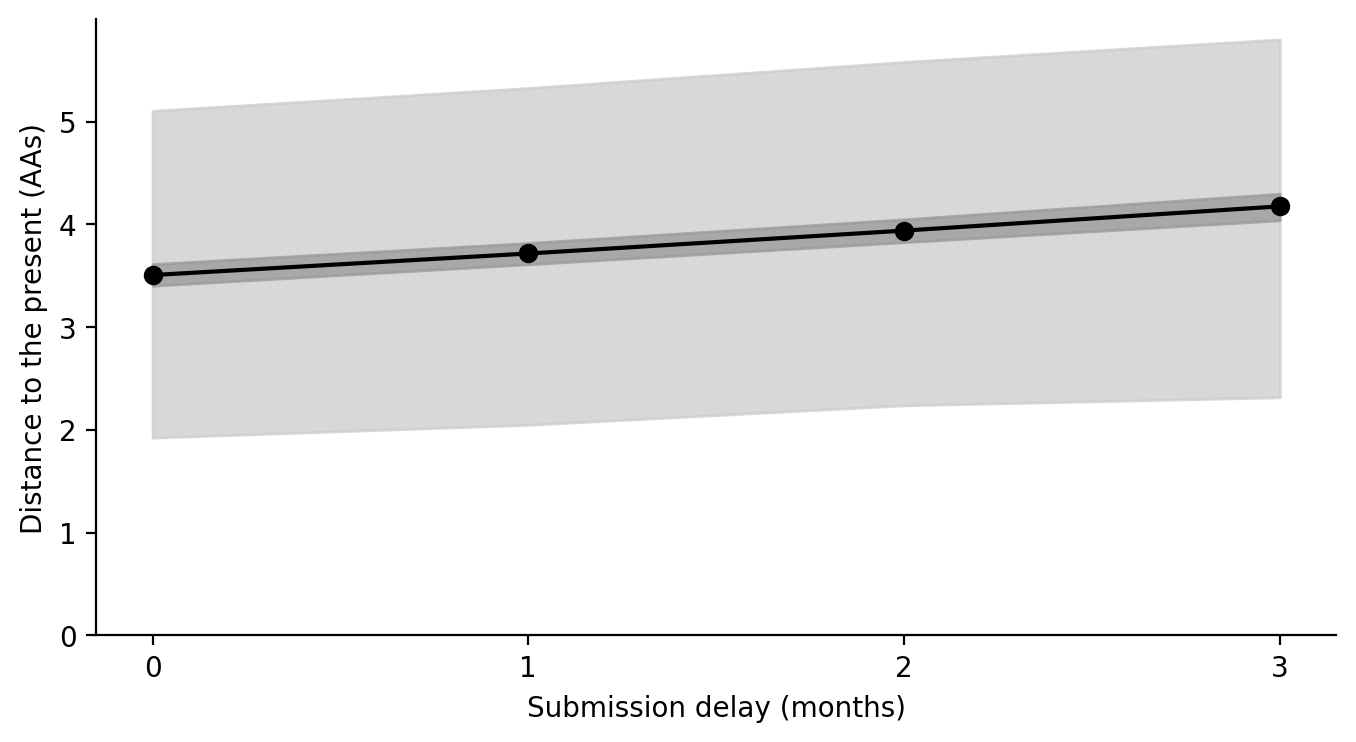

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

ax.plot(
    delay_seq,
    mu_mean_for_delays,
    "o-",
    color="#000000",
)

ax.fill_between(
    delay_seq,
    y1=mu_lower_hpdi,
    y2=mu_upper_hpdi,
    color="#999999",
    alpha=0.75,
    zorder=-10
)

ax.fill_between(
    delay_seq,
    y1=distance_lower_hpdi,
    y2=distance_upper_hpdi,
    color="#CCCCCC",
    alpha=0.75,
    zorder=-20
)

ax.set_xticks(delay_seq)

ax.set_ylim(bottom=0)

ax.set_xlabel("Submission delay (months)")
ax.set_ylabel("Distance to the present (AAs)")

sns.despine()

## Plot effect of horizons and delays

In [107]:
horizon_seq = np.arange(3, 13, 3)

In [108]:
horizon_seq

array([ 3,  6,  9, 12])

In [110]:
horizon_seq_s

array([-1.32931631, -0.435221  ,  0.45887431,  1.35296963])

In [127]:
delay_seq = np.array([0, 1, 3])

In [134]:
posterior_simulated_distances = []
records = []

for horizon in horizon_seq:
    horizon_s = (horizon - horizon_mean) / horizon_sd
    
    for delay in delay_seq:
        delay_s = (delay - delay_mean) / delay_sd
        
        mu = np.exp(posterior["a"] + posterior["b_s"] * delay_s + posterior["b_h"] * horizon_s)
        mu_mean = mu.mean()

        mu_lower_hpdi, mu_upper_hpdi = az.hdi(mu.values, 0.89)

        scale = posterior["scale"]
        distance = gamma.rvs(a=mu / scale, scale=scale, random_state=rng)
        distance_lower_hpdi, distance_upper_hpdi = az.hdi(distance, 0.89)
        
        posterior_simulated_distances.append(
            pd.DataFrame({
                "horizon": horizon,
                "delay": delay,
                "distance": distance,
            })
        )

        records.append({
            "horizon": horizon,
            "delay": delay,
            "mu_mean": mu_mean,
            "mu_lower_hpdi": mu_lower_hpdi,
            "mu_upper_hpdi": mu_upper_hpdi,
            "distance_lower_hpdi": distance_lower_hpdi,
            "distance_upper_hpdi": distance_upper_hpdi,
        })

In [135]:
df = pd.DataFrame(records)

In [136]:
df.head()

,horizon,delay,mu_mean,mu_lower_hpdi,mu_upper_hpdi,distance_lower_hpdi,distance_upper_hpdi
0,3,0,4.108323,4.010319,4.196335,2.310818,5.728230
1,3,1,4.354283,4.269156,4.439650,2.568561,6.170083
2,3,3,4.891669,4.778914,5.008714,3.081130,6.917065
3,6,0,4.813471,4.729069,4.894302,2.849685,6.573894
4,6,1,5.101646,5.035806,5.166784,3.075643,6.995497


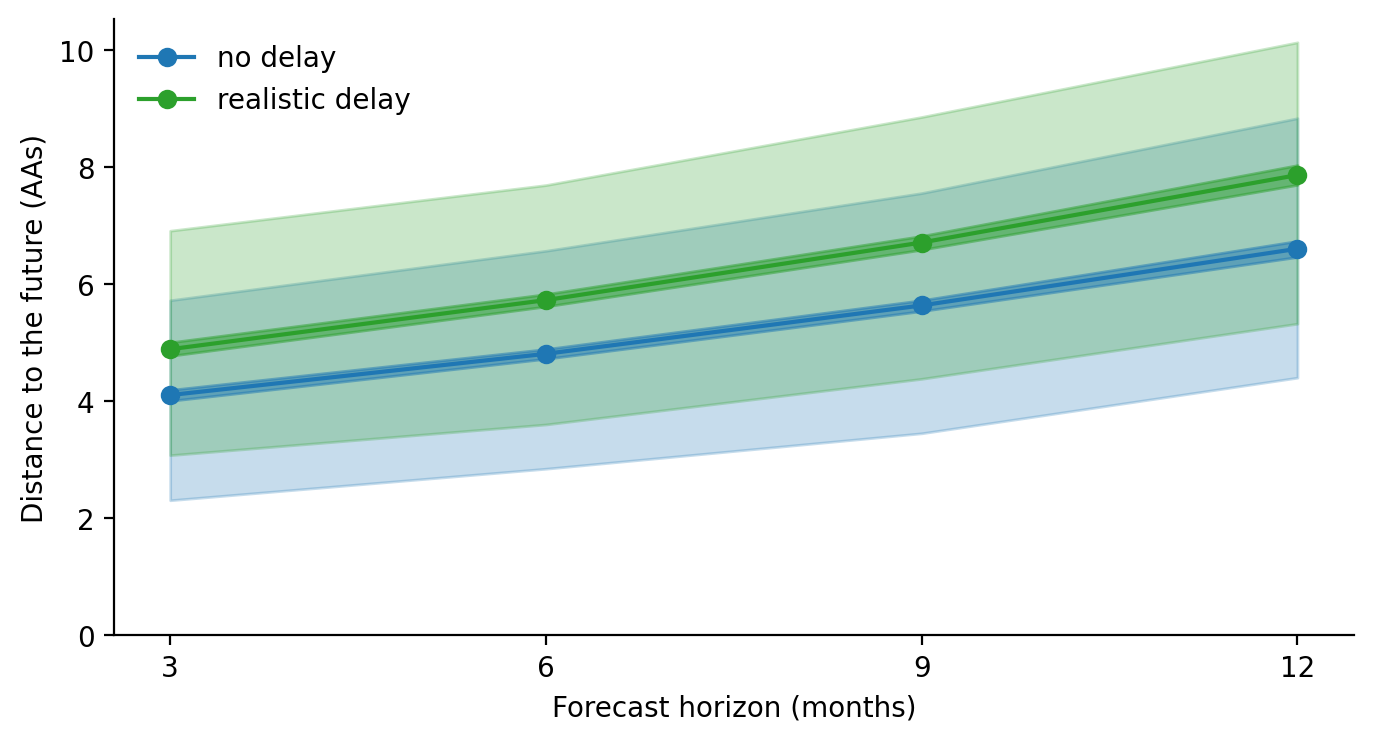

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

# Distance to the future without delay
ax.plot(
    df.query("delay == 0")["horizon"],
    df.query("delay == 0")["mu_mean"],
    "o-",
    color="C0",
    label="no delay",
)

ax.fill_between(
    df.query("delay == 0")["horizon"],
    y1=df.query("delay == 0")["mu_lower_hpdi"],
    y2=df.query("delay == 0")["mu_upper_hpdi"],
    color="C0",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 0")["horizon"],
    y1=df.query("delay == 0")["distance_lower_hpdi"],
    y2=df.query("delay == 0")["distance_upper_hpdi"],
    color="C0",
    alpha=0.25,
    zorder=-20
)

# Distance to the future with delay
ax.plot(
    df.query("delay == 3")["horizon"],
    df.query("delay == 3")["mu_mean"],
    "o-",
    color="C2",
    label="realistic delay",
)

ax.fill_between(
    df.query("delay == 3")["horizon"],
    y1=df.query("delay == 3")["mu_lower_hpdi"],
    y2=df.query("delay == 3")["mu_upper_hpdi"],
    color="C2",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 3")["horizon"],
    y1=df.query("delay == 3")["distance_lower_hpdi"],
    y2=df.query("delay == 3")["distance_upper_hpdi"],
    color="C2",
    alpha=0.25,
    zorder=-20
)

ax.set_xticks(horizon_seq)

ax.set_ylim(bottom=0)

ax.set_xlabel("Forecast horizon (months)")
ax.set_ylabel("Distance to the future (AAs)")

ax.legend(
    loc="upper left",
    frameon=False,
)

sns.despine()

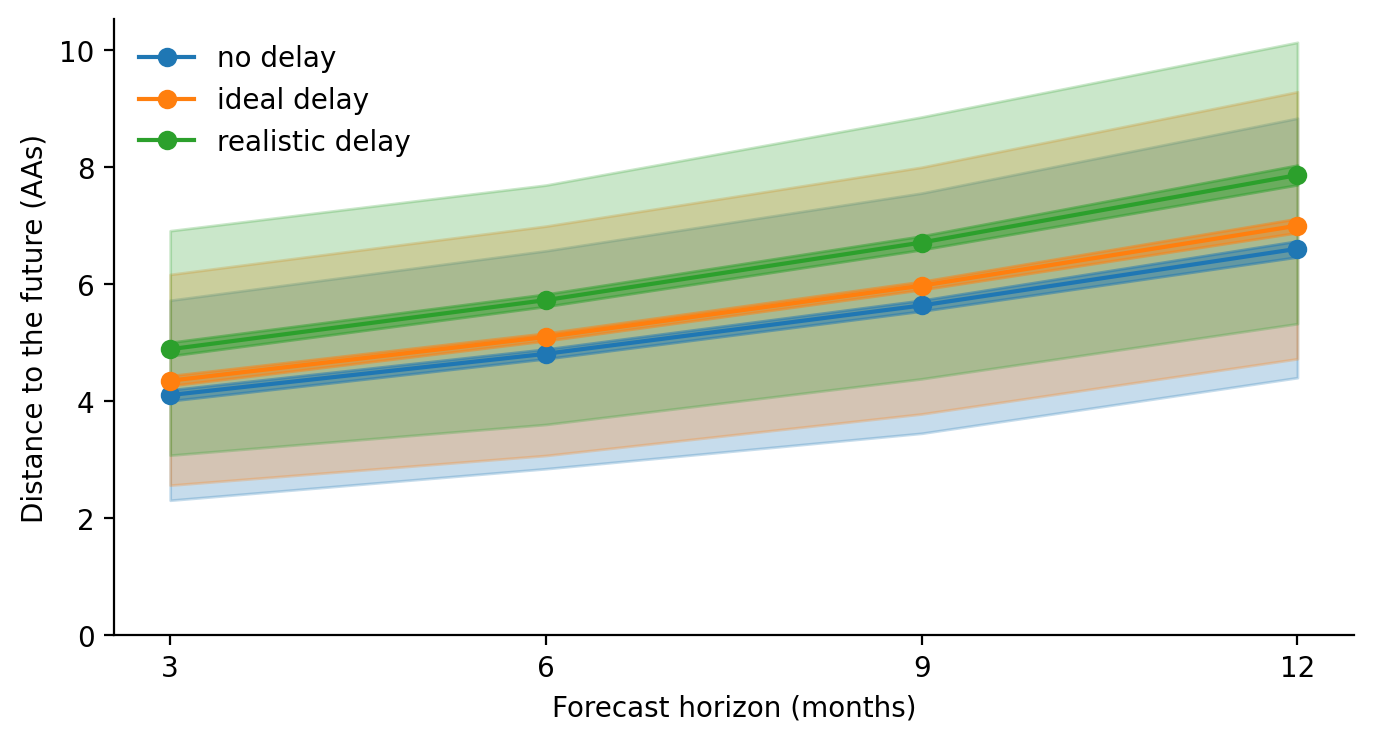

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

# Distance to the future without delay
ax.plot(
    df.query("delay == 0")["horizon"],
    df.query("delay == 0")["mu_mean"],
    "o-",
    color="C0",
    label="no delay",
)

ax.fill_between(
    df.query("delay == 0")["horizon"],
    y1=df.query("delay == 0")["mu_lower_hpdi"],
    y2=df.query("delay == 0")["mu_upper_hpdi"],
    color="C0",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 0")["horizon"],
    y1=df.query("delay == 0")["distance_lower_hpdi"],
    y2=df.query("delay == 0")["distance_upper_hpdi"],
    color="C0",
    alpha=0.25,
    zorder=-20
)

# Distance to the future with delay
ax.plot(
    df.query("delay == 1")["horizon"],
    df.query("delay == 1")["mu_mean"],
    "o-",
    color="C1",
    label="ideal delay",
)

ax.fill_between(
    df.query("delay == 1")["horizon"],
    y1=df.query("delay == 1")["mu_lower_hpdi"],
    y2=df.query("delay == 1")["mu_upper_hpdi"],
    color="C1",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 1")["horizon"],
    y1=df.query("delay == 1")["distance_lower_hpdi"],
    y2=df.query("delay == 1")["distance_upper_hpdi"],
    color="C1",
    alpha=0.25,
    zorder=-20
)

# Distance to the future with delay
ax.plot(
    df.query("delay == 3")["horizon"],
    df.query("delay == 3")["mu_mean"],
    "o-",
    color="C2",
    label="realistic delay",
)

ax.fill_between(
    df.query("delay == 3")["horizon"],
    y1=df.query("delay == 3")["mu_lower_hpdi"],
    y2=df.query("delay == 3")["mu_upper_hpdi"],
    color="C2",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 3")["horizon"],
    y1=df.query("delay == 3")["distance_lower_hpdi"],
    y2=df.query("delay == 3")["distance_upper_hpdi"],
    color="C2",
    alpha=0.25,
    zorder=-20
)

ax.set_xticks(horizon_seq)

ax.set_ylim(bottom=0)

ax.set_xlabel("Forecast horizon (months)")
ax.set_ylabel("Distance to the future (AAs)")

ax.legend(
    loc="upper left",
    frameon=False,
)

sns.despine()

## Plot improvements under different realistic scenarios

We consider three possible realistic scenarios for future practice of influenza genomic surveillance and vaccine development:

1. A change in vaccine development reduces the required forecast horizon from 12 months to 6 months (e.g., through adoption of mRNA-based vaccines).
2. A change in genomic surveillance capacity and policy reduces the average submission delay of genomes to GISAID from 3 months to 1 month.
3. Both changes to vaccine development and genomic surveillance occur at once.

In [140]:
posterior_simulated_distance_df = pd.concat(posterior_simulated_distances)

In [142]:
posterior_simulated_distance_df.head()

,horizon,delay,distance
0,3,0,2.067293
1,3,0,5.276801
2,3,0,4.502868
3,3,0,5.396973
4,3,0,2.780738


Get difference in distances for scenario 1 where delay=3 and horizon=12 or 6.

In [147]:
scenario_1_improvement = (
    posterior_simulated_distance_df.query("(delay == 3) & (horizon == 12)")["distance"] - 
    posterior_simulated_distance_df.query("(delay == 3) & (horizon == 6)")["distance"]
)

In [149]:
scenario_1_improvement.mean()

2.1292132826246357

Get difference in distances for scenario 2 where horizon=12 and delay=3 or 1.

In [150]:
scenario_2_improvement = (
    posterior_simulated_distance_df.query("(delay == 3) & (horizon == 12)")["distance"] - 
    posterior_simulated_distance_df.query("(delay == 1) & (horizon == 12)")["distance"]
)

In [151]:
scenario_2_improvement.mean()

0.8638690689405152

Finally, get difference in distances for scenario 3 where horizon/delay is either 12/3 or 6/1.

In [152]:
scenario_3_improvement = (
    posterior_simulated_distance_df.query("(delay == 3) & (horizon == 12)")["distance"] - 
    posterior_simulated_distance_df.query("(delay == 1) & (horizon == 6)")["distance"]
)

In [153]:
scenario_3_improvement.mean()

2.7496351113997144

In [154]:
bins = np.arange(
    min(scenario_1_improvement.min(), scenario_2_improvement.min(), scenario_3_improvement.min()),
    max(scenario_1_improvement.max(), scenario_2_improvement.max(), scenario_3_improvement.max()) + 0.1,
    0.25,
)

In [155]:
bins

array([-7.4811776, -7.2311776, -6.9811776, -6.7311776, -6.4811776,
       -6.2311776, -5.9811776, -5.7311776, -5.4811776, -5.2311776,
       -4.9811776, -4.7311776, -4.4811776, -4.2311776, -3.9811776,
       -3.7311776, -3.4811776, -3.2311776, -2.9811776, -2.7311776,
       -2.4811776, -2.2311776, -1.9811776, -1.7311776, -1.4811776,
       -1.2311776, -0.9811776, -0.7311776, -0.4811776, -0.2311776,
        0.0188224,  0.2688224,  0.5188224,  0.7688224,  1.0188224,
        1.2688224,  1.5188224,  1.7688224,  2.0188224,  2.2688224,
        2.5188224,  2.7688224,  3.0188224,  3.2688224,  3.5188224,
        3.7688224,  4.0188224,  4.2688224,  4.5188224,  4.7688224,
        5.0188224,  5.2688224,  5.5188224,  5.7688224,  6.0188224,
        6.2688224,  6.5188224,  6.7688224,  7.0188224,  7.2688224,
        7.5188224,  7.7688224,  8.0188224,  8.2688224,  8.5188224,
        8.7688224,  9.0188224,  9.2688224,  9.5188224,  9.7688224,
       10.0188224, 10.2688224, 10.5188224, 10.7688224, 11.0188

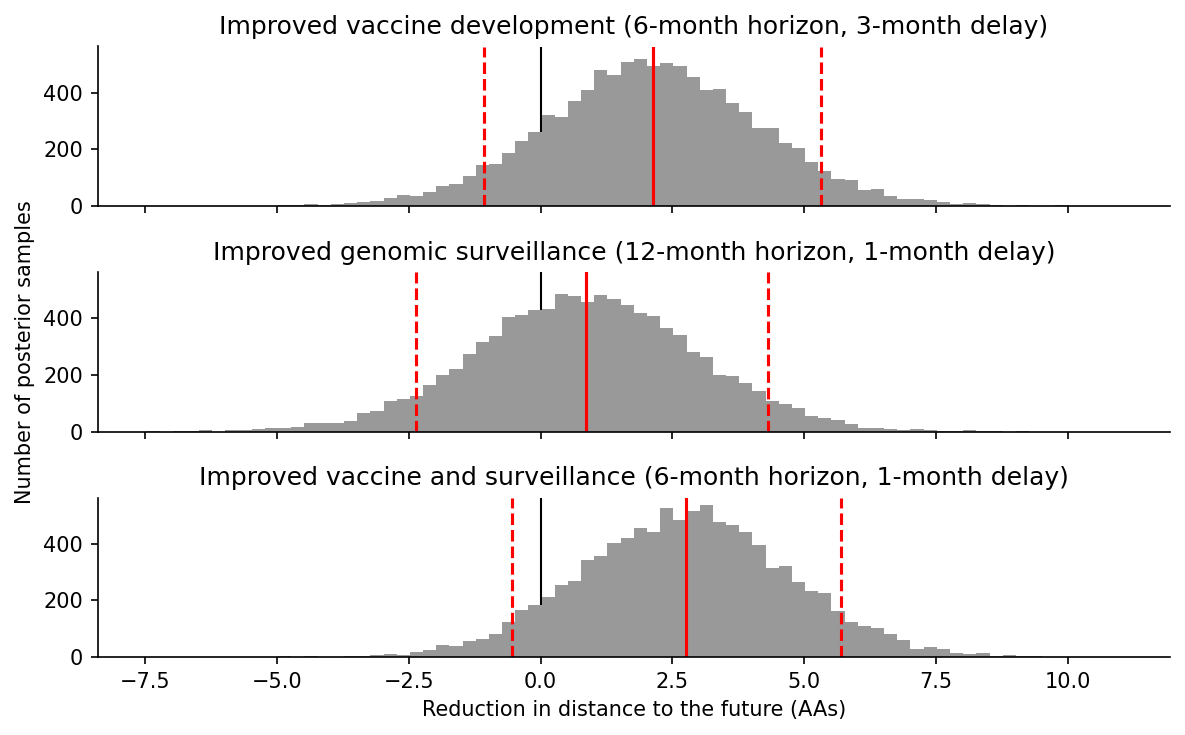

In [185]:
fig, axes = plt.subplots(3, 1, figsize=(8, 5), dpi=150, sharex=True, sharey=True)
all_axes = axes.flatten()

# Scenario 1
ax1 = all_axes[0]
ax1.hist(
    scenario_1_improvement,
    bins=bins,
    color="#999999",
)
ax1.axvline(x=0, color="#000000", zorder=-10, linewidth=1)
ax1.axvline(x=scenario_1_improvement.mean(), color="red")
ax1.axvline(x=az.hdi(scenario_1_improvement.values, 0.89)[0], color="red", linestyle="--")
ax1.axvline(x=az.hdi(scenario_1_improvement.values, 0.89)[1], color="red", linestyle="--")

ax1.set_title("Improved vaccine development (6-month horizon, 3-month delay)")

# Scenario 2
ax2 = all_axes[1]
ax2.hist(
    scenario_2_improvement,
    bins=bins,
    color="#999999",
)
ax2.axvline(x=0, color="#000000", zorder=-10, linewidth=1)
ax2.axvline(x=scenario_2_improvement.mean(), color="red")
ax2.axvline(x=az.hdi(scenario_2_improvement.values, 0.89)[0], color="red", linestyle="--")
ax2.axvline(x=az.hdi(scenario_2_improvement.values, 0.89)[1], color="red", linestyle="--")

ax2.set_ylabel("Number of posterior samples")
ax2.set_title("Improved genomic surveillance (12-month horizon, 1-month delay)")

# Scenario 3
ax3 = all_axes[2]
ax3.hist(
    scenario_3_improvement,
    bins=bins,
    color="#999999",
)
ax3.axvline(x=0, color="#000000", zorder=-10, linewidth=1)
ax3.axvline(x=scenario_3_improvement.mean(), color="red")
ax3.axvline(x=az.hdi(scenario_3_improvement.values, 0.89)[0], color="red", linestyle="--")
ax3.axvline(x=az.hdi(scenario_3_improvement.values, 0.89)[1], color="red", linestyle="--")

ax3.set_xlabel("Reduction in distance to the future (AAs)")
ax3.set_title("Improved vaccine and surveillance (6-month horizon, 1-month delay)")

sns.despine()
plt.tight_layout()